In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import webbrowser
from scipy.stats import chi2
import numpy as np
import statsmodels.api as sm
'''
from statsmodels.iolib.summary2 import summary_col
'''
from statsmodels.stats.diagnostic import het_breuschpagan
lowess = sm.nonparametric.lowess
import seaborn as sns
import matplotlib.image as mpimg

In [2]:
os.getcwd()

# Write or choose your path here !!! >>
path = "C:/Users/mixas/binary 2"

fileName = "titanic"
os.chdir(path)

from my_tests import tabstat
from my_summary_col import summary_col
#%%
# Read Stata variable labels as dictionary >>
# key is Stata's varName
# value is Stata's label
labels = pd.read_stata(fileName +'.dta', iterator=True)

display(labels.variable_labels())

{'survived': 'Survived',
 'pclass': 'Pclass',
 'name': 'Name',
 'sex': 'Sex',
 'male': 'Male',
 'age': 'Age',
 'siblingsspousesaboard': 'Siblings/Spouses Aboard',
 'parentschildrenaboard': 'Parents/Children Aboard',
 'fare': 'Fare',
 'lf': 'Log of 1 + fare',
 'age2': 'Age^2/100',
 'lf2': '(Log of 1 + fare)^2/100'}

In [3]:
# read data >>
dfall = pd.read_stata(fileName +'.dta')

print('\n',dfall.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 886
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survived               887 non-null    int8   
 1   pclass                 887 non-null    int8   
 2   name                   887 non-null    object 
 3   sex                    887 non-null    object 
 4   male                   887 non-null    int8   
 5   age                    887 non-null    float32
 6   siblingsspousesaboard  887 non-null    int8   
 7   parentschildrenaboard  887 non-null    int8   
 8   fare                   887 non-null    float32
 9   lf                     887 non-null    float32
 10  age2                   887 non-null    float32
 11  lf2                    887 non-null    float32
dtypes: float32(5), int8(5), object(2)
memory usage: 42.4+ KB

 None


In [4]:
# Descriptive statistics >>
display(tabstat(2,dfall))

,count,mean,std,min,max
survived,887.0,0.39,0.49,0.00,1.00
pclass,887.0,2.31,0.84,1.00,3.00
male,887.0,0.65,0.48,0.00,1.00
age,887.0,29.47,14.12,0.42,80.00
siblingsspousesaboard,887.0,0.53,1.10,0.00,8.00
parentschildrenaboard,887.0,0.38,0.81,0.00,6.00
fare,887.0,32.31,49.78,0.00,512.33
lf,887.0,2.97,0.97,0.00,6.24
age2,887.0,10.68,9.65,0.00,64.00
lf2,887.0,0.10,0.06,0.00,0.39


In [5]:
# 'normalize' is dividing all values by the sum of values >>
print('\n', pd.crosstab(dfall.pclass, columns="count",
                        normalize=True),
  '\n', pd.crosstab(dfall.siblingsspousesaboard, columns="count",
                    normalize=True),
  '\n', pd.crosstab(dfall.parentschildrenaboard, columns="count",
                    normalize=True))

display(pd.crosstab(dfall.sex, dfall.male))


 col_0      count
pclass          
1       0.243517
2       0.207441
3       0.549042 
 col_0                     count
siblingsspousesaboard          
0                      0.680947
1                      0.235626
2                      0.031567
3                      0.018038
4                      0.020293
5                      0.005637
8                      0.007892 
 col_0                     count
parentschildrenaboard          
0                      0.759865
1                      0.133033
2                      0.090192
3                      0.005637
4                      0.004510
5                      0.005637
6                      0.001127


male,0,1
sex,,
female,314,0
male,0,573


In [6]:
## What about life survival ?
#
model='survived ~ C(pclass) + male + age + age2 + \
    C(siblingsspousesaboard) + C(parentschildrenaboard) + lf'

o1 = sm.OLS.from_formula(model, data=dfall).fit()
print('\n',o1.summary())

info_dict={'Observations' : lambda x: f"{int(x.nobs):d}",
        'Adj. R-sq.' : lambda x: f"{x.rsquared_adj:.3f}",
        'F' : lambda x: f"{x.fvalue:.1f}",
        'F p-value' : lambda x: f"{x.f_pvalue:.3f}"}
results_table = summary_col(results=o1,
                            float_format='%0.3f',
                            stars = True,
                            info_dict=info_dict)
results_table.add_title('OLS Regression')
print('\n',results_table)


                             OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     34.64
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           2.94e-89
Time:                        03:20:36   Log-Likelihood:                -379.81
No. Observations:                 887   AIC:                             797.6
Df Residuals:                     868   BIC:                             888.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept   

In [7]:
## Probit
#
p6 = sm.Probit.from_formula(model, data=dfall).fit()

info_dictch={'Observations' : lambda x: f"{int(x.nobs):d}",
        'Adj. R-sq.' : lambda x: f"{x.rsquared_adj:.3f}",
        'F' : lambda x: f"{x.fvalue:.1f}",
        'F p-value' : lambda x: f"{x.f_pvalue:.3f}",
        'Pseudo R-sq.' : lambda x: f"{x.prsquared:.3f}",
        'chi2' : lambda x: f"{2*(x.llf-x.llnull):.1f}",
        'chi2 p-value' : lambda x: f"{x.llr_pvalue:.3f}"}

results_table = summary_col(results=[o1,p6],
                            float_format='%0.3f',
                            stars = True,
                            model_names=['OLS','Probit'],
                            info_dict=info_dictch)
results_table.add_title(labels.variable_labels()['survived'] + \
                        ' binary is dependent variable')
print('\n',results_table)

         Current function value: 0.427019
         Iterations: 35

         Survived binary is dependent variable
                                 OLS        Probit    
------------------------------------------------------
Intercept                     1.026***  1.777***      
                              (0.114)   (0.469)       
C(pclass)[T.2]                -0.137*** -0.508***     
                              (0.048)   (0.192)       
C(pclass)[T.3]                -0.276*** -1.009***     
                              (0.050)   (0.207)       
C(siblingsspousesaboard)[T.1] -0.010    -0.088        
                              (0.034)   (0.136)       
C(siblingsspousesaboard)[T.2] -0.081    -0.330        
                              (0.076)   (0.312)       
C(siblingsspousesaboard)[T.3] -0.469*** -1.621***     
                              (0.102)   (0.402)       
C(siblingsspousesaboard)[T.4] -0.354*** -1.207***     
                              (0.101)   (0.424)       
C(sibl

C:\Users\mixas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
## Logit
#
### Singular matrix !!! >>>
l6=sm.Logit.from_formula(model, data=dfall).fit()

results_table = summary_col(results=[o1,p6,l6],
                            float_format='%0.3f',
                            stars = True,
                            model_names=['OLS','Probit','Logit'],
                            info_dict=info_dictch)
results_table.add_title(labels.variable_labels()['survived'] + \
                        ' binary is dependent variable')
print('\n',results_table)

C:\Users\mixas\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\mixas\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [9]:
## create dummies >>
#
# Creating dummy variables for categorical datatypes
dfall['parch']=dfall["parentschildrenaboard"]
dfall = pd.get_dummies(dfall, columns=["parch"])
display(dfall.columns.tolist())

['survived',
 'pclass',
 'name',
 'sex',
 'male',
 'age',
 'siblingsspousesaboard',
 'parentschildrenaboard',
 'fare',
 'lf',
 'age2',
 'lf2',
 'parch_0',
 'parch_1',
 'parch_2',
 'parch_3',
 'parch_4',
 'parch_5',
 'parch_6']

In [10]:
# Creating dummy variables for categorical datatypes
dfall['sibsp']=dfall["siblingsspousesaboard"]
dfall = pd.get_dummies(dfall, columns=["sibsp"])
display(dfall.columns.tolist())

['survived',
 'pclass',
 'name',
 'sex',
 'male',
 'age',
 'siblingsspousesaboard',
 'parentschildrenaboard',
 'fare',
 'lf',
 'age2',
 'lf2',
 'parch_0',
 'parch_1',
 'parch_2',
 'parch_3',
 'parch_4',
 'parch_5',
 'parch_6',
 'sibsp_0',
 'sibsp_1',
 'sibsp_2',
 'sibsp_3',
 'sibsp_4',
 'sibsp_5',
 'sibsp_8']

In [11]:
model2='survived ~ C(pclass) + male + age + age2 + \
    sibsp_1 + sibsp_2+ sibsp_3+ sibsp_4 + \
        parch_1+ parch_2+ parch_3 + \
        + parch_5 + lf'

l7=sm.Logit.from_formula(model2, data=dfall).fit()

results_table = summary_col(results=[o1,p6, l7],
                            float_format='%0.3f',
                            stars = True,
                            model_names=['OLS','Probit','Logit'],
                            info_dict=info_dictch)
results_table.add_title(labels.variable_labels()['survived'] + \
                        ' binary is dependent variable')
print('\n',results_table)

Optimization terminated successfully.
         Current function value: 0.437515
         Iterations 6

              Survived binary is dependent variable
                                 OLS        Probit       Logit  
----------------------------------------------------------------
C(parentschildrenaboard)[T.1] 0.025     0.045                   
                              (0.044)   (0.179)                 
C(parentschildrenaboard)[T.2] -0.025    -0.204                  
                              (0.056)   (0.229)                 
C(parentschildrenaboard)[T.3] 0.032     0.072                   
                              (0.171)   (0.639)                 
C(parentschildrenaboard)[T.4] -0.418**  -6.357                  
                              (0.191)   (3805.796)              
C(parentschildrenaboard)[T.5] -0.287*   -0.948                  
                              (0.172)   (0.690)                 
C(parentschildrenaboard)[T.6] -0.585    -6.793                  


In [12]:
# Marginal Effects and OLS
print('\n',l7.get_margeff().summary(),
      '\n',summary_col(o1,stars=True,
                       float_format='%0.4f'))


         Logit Marginal Effects       
Dep. Variable:               survived
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
C(pclass)[T.2]    -0.1561      0.043     -3.605      0.000      -0.241      -0.071
C(pclass)[T.3]    -0.3109      0.044     -6.996      0.000      -0.398      -0.224
male              -0.3781      0.016    -23.986      0.000      -0.409      -0.347
age               -0.0109      0.003     -3.211      0.001      -0.018      -0.004
age2               0.0075      0.005      1.568      0.117      -0.002       0.017
sibsp_1           -0.0021      0.032     -0.065      0.948      -0.065       0.061
sibsp_2           -0.0511      0.075     -0.677      0.498      -0.199       0.097
sibsp_3           -0.3451      0.094     -3.674      0.000      -0.529      -0.161
sibsp_4         

In [13]:
# predicted values
o1hat=o1.predict(dfall)
l7hat=l7.predict(dfall)

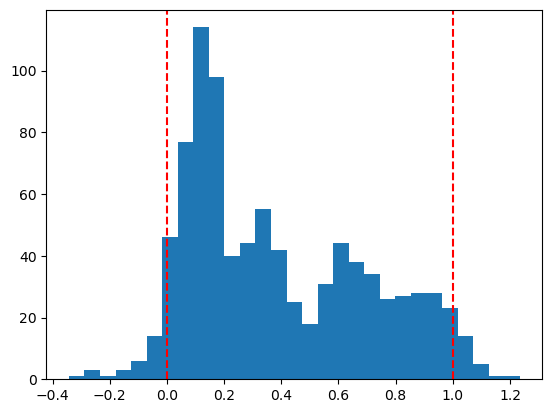

In [14]:
bins = np.linspace(o1hat.min(), o1hat.max(), 30)
plt.hist(o1hat, bins)
plt.axvline(0, color="r", linestyle="--")
plt.axvline(1, color="r", linestyle="--")

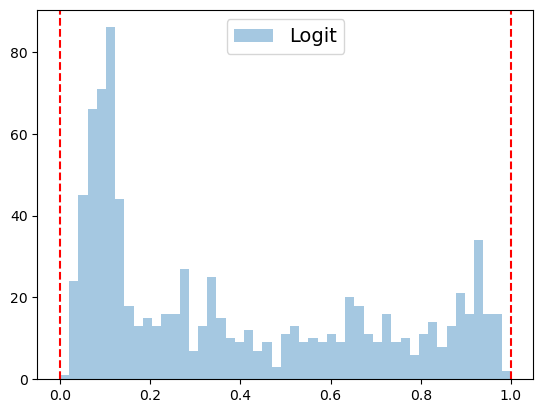

In [15]:
bins = np.linspace(0, 1, 50)
plt.hist(l7hat, bins,alpha=0.4, label='Logit')
plt.axvline(0, color="r", linestyle="--")
plt.axvline(1, color="r", linestyle="--")
plt.legend(loc='best', fontsize=14)

In [16]:
# null hypothesis of homoskedasticity >>
# Breush-Pagan test
name = 'chi-squared, p-value;   F, p-value'
t = het_breuschpagan(o1.resid, o1.model.exog)
print('\n', name,'\n  ',np.around(t, decimals=3))


 chi-squared, p-value;   F, p-value 
   [18.579  0.418  1.032  0.42 ]


(array([545.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 342.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <BarContainer object of 29 artists>)

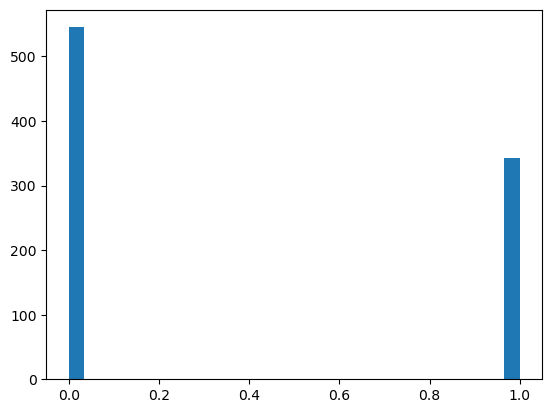

In [17]:
bins = np.linspace(0, 1, 30)
plt.hist(dfall['survived'], bins)

In [18]:
# mean values comparison
print('\n Mean values of predicted values and dependent variable',
      '\n Logit {:31}'.format(l7hat.describe()['mean']),
      '\n Dependent variable',
      dfall['survived'].describe()['mean'])


 Mean values of predicted values and dependent variable 
 Logit              0.3855693348365276 
 Dependent variable 0.3855693348365276


In [19]:
# odds ratio output for Logit model
model_odds = pd.DataFrame(np.round(np.exp(l7.params),2),
                          columns= ['OR'])
model_odds['p-value']=np.round(l7.pvalues,3)
model_odds[['2.5%', '97.5%']]=np.round(np.exp(l7.conf_int()),
                                         2)
print('\n',model_odds)


                    OR  p-value   2.5%   97.5%
Intercept       50.06    0.000  10.71  234.04
C(pclass)[T.2]   0.33    0.000   0.18    0.61
C(pclass)[T.3]   0.11    0.000   0.05    0.21
male             0.07    0.000   0.04    0.10
age              0.92    0.002   0.88    0.97
age2             1.06    0.118   0.99    1.13
sibsp_1          0.99    0.948   0.63    1.55
sibsp_2          0.69    0.499   0.24    2.00
sibsp_3          0.08    0.000   0.02    0.33
sibsp_4          0.18    0.024   0.04    0.80
parch_1          1.15    0.647   0.63    2.09
parch_2          0.56    0.120   0.27    1.16
parch_3          1.30    0.801   0.17    9.98
parch_5          0.31    0.316   0.03    3.08
lf               1.19    0.240   0.89    1.60


In [20]:
l7hat.isnull().sum()

dtmp=pd.DataFrame()
dtmp['ph']=l7.predict(dfall)
dtmp['p']=dfall['survived']

pih=dtmp.dropna()
pih.isnull().sum()

pihat=pih['ph']

In [21]:
# only 4 groups
pihatcat=pd.cut(pihat, np.percentile(pihat,[0,25,50,75,100]),
                labels=False,include_lowest=True)

meanprobs =[0]*4
expevents =[0]*4
obsevents =[0]*4
meanprobs2=[0]*4
expevents2=[0]*4
obsevents2=[0]*4

for i in range(4):
   meanprobs[i]=np.mean(pihat[pihatcat==i])
   expevents[i]=np.sum(pihatcat==i)*np.array(meanprobs[i])
   obsevents[i]=np.sum(pih['p'][pihatcat==i])
   meanprobs2[i]=np.mean(1-pihat[pihatcat==i])
   expevents2[i]=np.sum(pihatcat==i)*np.array(meanprobs2[i])
   obsevents2[i]=np.sum(1-pih['p'][pihatcat==i]) 


data1={'meanprobs':meanprobs,'meanprobs2':meanprobs2}
data2={'expevents':expevents,'expevents2':expevents2}
data3={'obsevents':obsevents,'obsevents2':obsevents2}
m=pd.DataFrame(data1)
e=pd.DataFrame(data2)
o=pd.DataFrame(data3)

# The statistic for the test, which follows, under the null hypothesis,
# The chi-squared distribution with degrees of freedom equal
# to amount of groups - 2. Thus 4 - 2 = 2
tt=sum(sum((np.array(o)-np.array(e))**2/np.array(e))) 
pvalue=1-chi2.cdf(tt,2)

print('\n Hosmer and Lemesbow (1980) p-value',
      '\n', np.round(pvalue,3))


 Hosmer and Lemesbow (1980) p-value 
 0.001


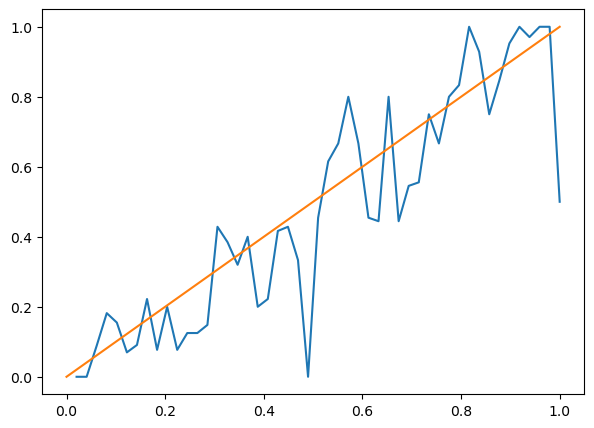

In [22]:
##
### Locally weighted regression (Cleveland, 1979) plot
##

# choose model here >>>
dephat=l7.predict(dfall)

#%%
tmp=pd.DataFrame()
tmp['dephat']=dephat
tmp['bdep']=dfall['survived']

tmp
tmp.sort_values(by=['dephat'], inplace=True)
tmp.dropna(subset=['dephat'], inplace=True)

#%%
# choose # of points here >>>
points=50

lws=pd.DataFrame()
lws['x'] = np.linspace(0, 1, points)
lws['y'] = lws['x'] #+.5/points
lws['m'] = np.nan

for i in range(points-1):
#    print('\n', i, lws.loc[i,'x'], lws.loc[i+1,'x'])
    lws.loc[i+1,'m']=tmp['bdep'][(dephat>lws.loc[i,'x']) &
                                (dephat<lws.loc[i+1,'x'])].describe()['mean']

plt.figure(figsize=(7,5))
plt.plot(lws['x'], lws['m'])
plt.plot(lws['x'], lws['y'])

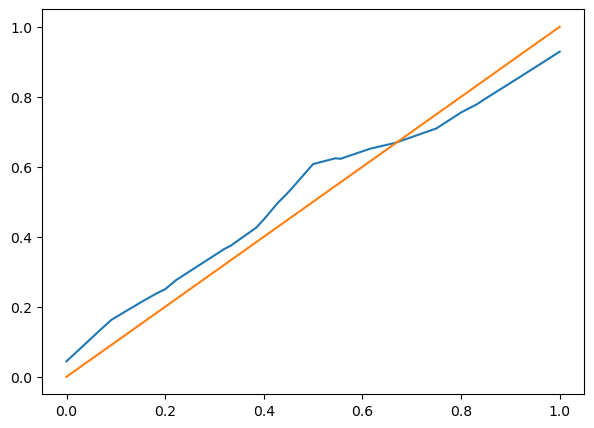

In [23]:
#
## some ones which were rarely occur were unpredicted >>>
#
w = lowess(lws['y'], lws['m'], frac=1./3)
plt.figure(figsize=(7,5))
plt.plot(w[:,0], w[:,1])
plt.plot(np.linspace(0, 1, points), np.linspace(0, 1, points))

In [24]:
#
## Male vs Female
#
dfm=dfall[dfall.male==1]
dff=dfall[dfall.male==0]

modelmf='survived ~ C(pclass) + age + age2 + \
    C(siblingsspousesaboard) + C(parentschildrenaboard) + lf'

lm=sm.Probit.from_formula(modelmf, data=dfm).fit()
lf=sm.Probit.from_formula(modelmf, data=dff).fit()

results_table = summary_col(results=[lm,lf],
                            float_format='%0.3f',
                            stars = True,
                            model_names=['Male','Female'],
                            info_dict=info_dictch)
results_table.add_title(labels.variable_labels()['survived'] + \
                        ' binary is dependent variable, Probit')
print('\n',results_table)

         Current function value: 0.404903
         Iterations: 35
         Current function value: 0.386278
         Iterations: 35

                                       Survived binary is dependent variable, Probit
                                    Male                                         Female                                  
-------------------------------------------------------------------------------------------------------------------------
C(parentschildrenaboard)[T.1] 0.009           -0.006                                                                     
                              (0.261)         (0.291)                                                                    
C(parentschildrenaboard)[T.2] 0.325           -0.513                                                                     
                              (0.392)         (0.357)                                                                    
C(parentschildrenaboard)[T.3] -5.623          0.28

C:\Users\mixas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mixas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
modelm='survived ~ C(pclass) + age + age2 + \
    sibsp_1 + sibsp_2+ sibsp_4 + \
        parch_1+ parch_2+ lf'
modelf='survived ~ C(pclass) + age + age2 + \
    sibsp_1 + sibsp_2+ sibsp_3+ sibsp_4 + \
        parch_1+ parch_2+parch_3+ parch_5+ lf'

lm=sm.Logit.from_formula(modelm, data=dfm).fit()
lf=sm.Logit.from_formula(modelf, data=dff).fit()

results_table = summary_col(results=[lm,lf],
                            float_format='%0.3f',
                            stars = True,
                            model_names=['Male','Female'],
                            info_dict=info_dictch)
results_table.add_title(labels.variable_labels()['survived'] + \
                        ' binary is dependent variable, Logit')
print('\n',results_table)

Optimization terminated successfully.
         Current function value: 0.420631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395660
         Iterations 7

 Survived binary is dependent variable, Logit
                  Male     Female 
----------------------------------
C(pclass)[T.2] -1.725*** -2.265** 
               (0.428)   (1.049)  
C(pclass)[T.3] -1.799*** -5.256***
               (0.395)   (1.158)  
Intercept      1.827**   7.689*** 
               (0.910)   (2.251)  
age            -0.124*** -0.010   
               (0.032)   (0.043)  
age2           0.108**   -0.036   
               (0.042)   (0.072)  
lf             0.162     -0.662   
               (0.173)   (0.474)  
parch_1        -0.001    0.187    
               (0.425)   (0.499)  
parch_2        -0.487    -0.529   
               (0.582)   (0.605)  
parch_3                  1.022    
                         (1.466)  
parch_5                  -0.083   
              

col_0,0,1
survived,,
0,479,66
1,94,248


<Axes: xlabel='age', ylabel='survived'>

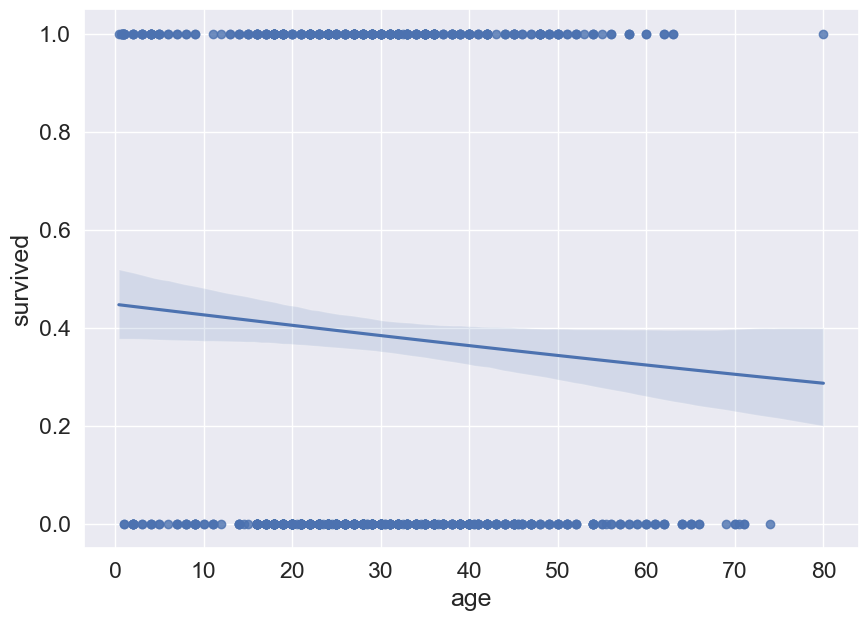

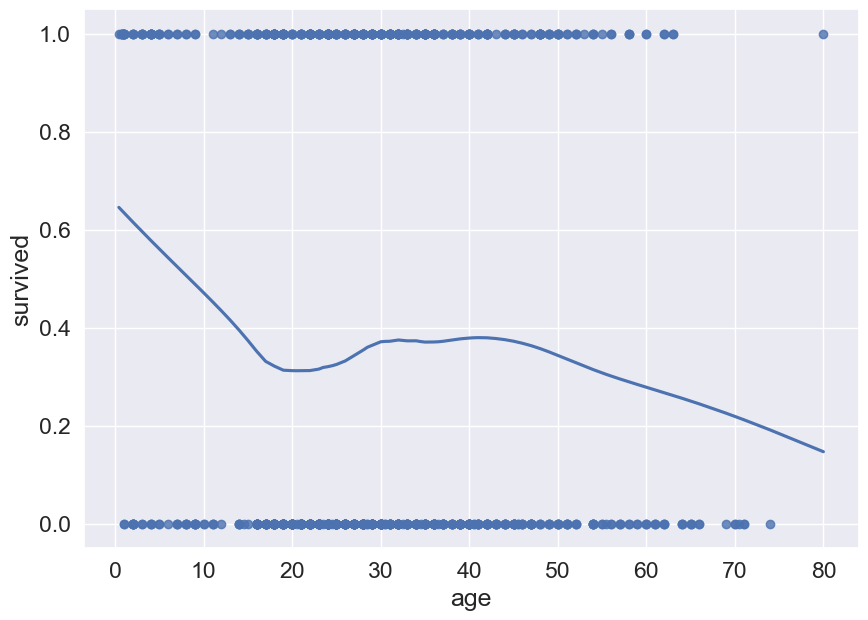

In [26]:
# True vs actual prediction >>
cutoff=.5

ypr=np.where(l7hat>cutoff, 1, 0)

display(pd.crosstab(dfall.survived, ypr))
#%%
sns.set(font_scale=1.5)
#%%
plt.figure(figsize=(10,7))
sns.regplot(x='age', y='survived', data=dfall,
            logistic=True)
#%%
plt.figure(figsize=(10,7))
sns.regplot(x='age', y='survived', data=dfall,
            lowess=True)

(-0.5, 957.5, 696.5, -0.5)

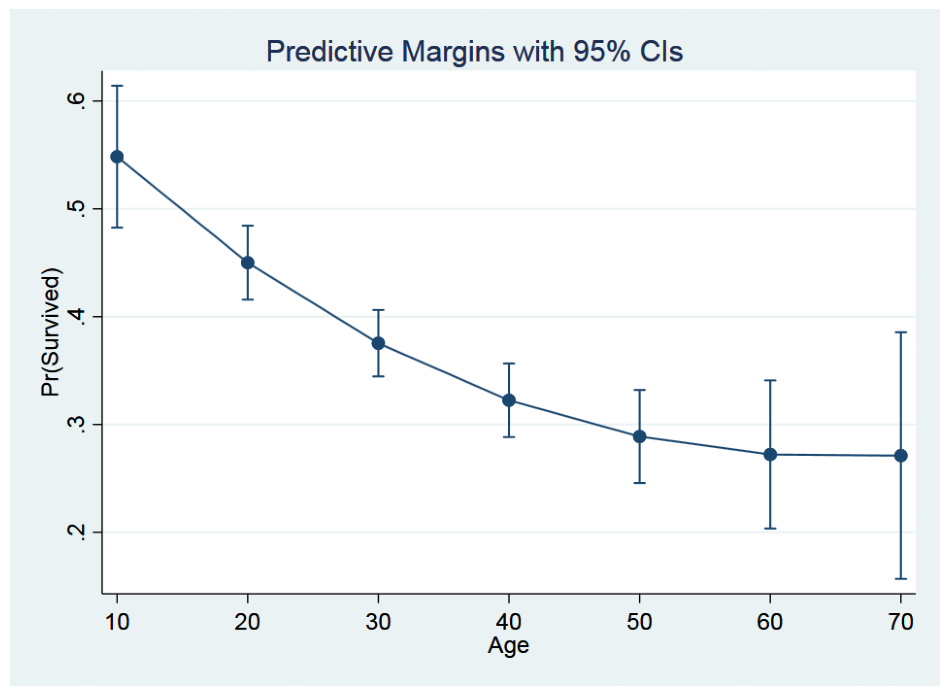

In [27]:
# margins from Stata logit with age and age^2 >>
img1 = mpimg.imread('titanic_margins_Stata.png')
plt.figure(figsize=(12,9))
plt.imshow(img1)
plt.axis('off')